# Demo Notebook

First, we import some libraries for image processing and utils, as well as tensorflow


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

### Data download

Now we will download our dataset used for training from an URL...

In [24]:
_URL = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
path_to_zip = tf.keras.utils.get_file('rps.zip', origin=_URL, extract=True, cache_dir=' ~/home/. ')
PATH = os.path.join(os.path.dirname(path_to_zip), "rps")


train_dir = PATH

BATCH_SIZE = 32
IMG_SIZE = (96, 96)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
                                             

Found 2520 files belonging to 3 classes.


As well as the validation dataset...

In [25]:
_URL2 = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
path_to_zip2 = tf.keras.utils.get_file('rps-test-set.zip', origin=_URL2, extract=True)
PATH2 = os.path.join(os.path.dirname(path_to_zip2), "rps-test-set")
validation_dir = PATH2

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  seed=123,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 372 files belonging to 3 classes.


Lets display some images of our dataset, as well as the class names...


Class names: ['paper', 'rock', 'scissors']
Number of classes: 3


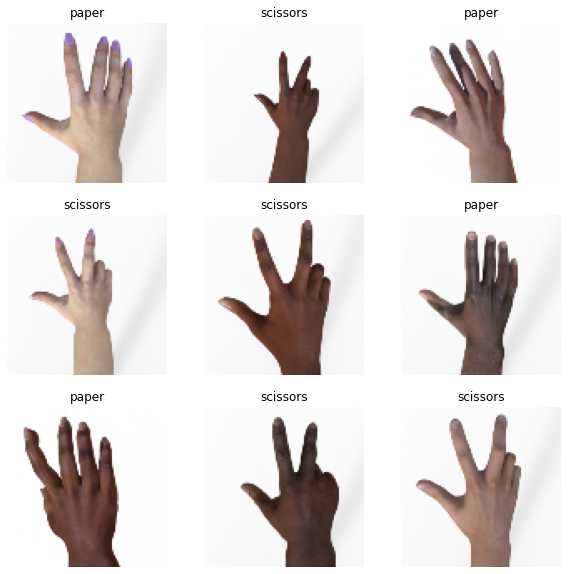

In [26]:
class_names = train_dataset.class_names
num_classes = len(train_dataset.class_names)
print("Class names:" , class_names)
print("Number of classes:", num_classes)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

We first want to normalize the color values of the input images to [0,1], which we can do via a keras model layer and apply it to our *datasets*:


In [27]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

train_dataset = train_dataset.map(
    lambda x, y: (normalization_layer(x), y))

validation_dataset = validation_dataset.map(
    lambda x, y: (normalization_layer(x), y))

We are now taking a fifth of the validation dataset to use as our test set, in order to prevent "overfitting" on the validation data:

In [28]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [29]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 10
Number of test batches: 2


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation


We want to add some random flips and rotations to the input images to get a more "varied" range of inputs, for that we define two preprocessing layers that the inputs pass in order:


In [31]:

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Note: These layers are active only during training, when you call `model.fit`. They are inactive when the model is used in inference mode in `model.evaulate` or `model.fit`.



Let's repeatedly apply these layers to the same image and see the result.

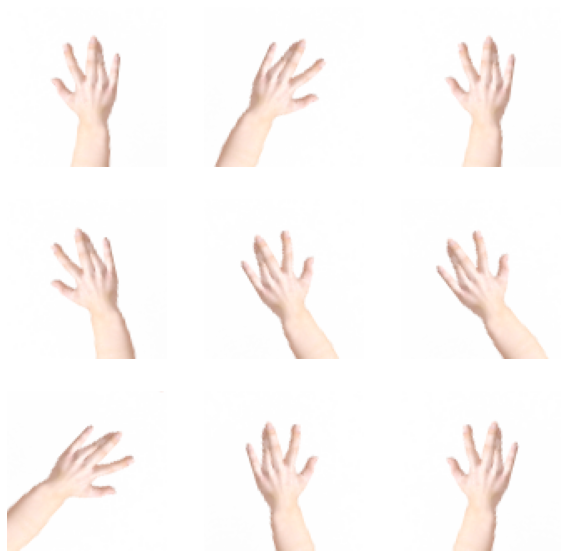

In [32]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

<h1> Create a model </h1>
Lets define a simple CNN with several convolutional layers, followed by max pooling layers and a dense layer (with some dropout layer in between to prevent overfitting). The first parameter of the layers is the amount of neurons that are in the layer

In [33]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Create the cnn model 
IMG_SHAPE = IMG_SIZE + (3,)
model = Sequential([
  layers.InputLayer(input_shape=IMG_SHAPE),
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model

Compile the model before training it. We can define the the used optimizer and the learning rate, the loss function, and which metrics to display while training: 

In [34]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


As well as printing out a summary of the model architecture:

In [35]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 16)        448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)       

### Train the model

Now we should train the model for 10 epochs and see...


In [36]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
79/79 [==============================] - 37s 90ms/step - loss: 1.0710 - accuracy: 0.4397 - val_loss: 0.8027 - val_accuracy: 0.6494
Epoch 2/10
79/79 [==============================] - 8s 89ms/step - loss: 0.4910 - accuracy: 0.8083 - val_loss: 0.5653 - val_accuracy: 0.7110
Epoch 3/10
79/79 [==============================] - 8s 88ms/step - loss: 0.2190 - accuracy: 0.9290 - val_loss: 0.2856 - val_accuracy: 0.8247
Epoch 4/10
79/79 [==============================] - 8s 89ms/step - loss: 0.1143 - accuracy: 0.9667 - val_loss: 0.1811 - val_accuracy: 0.9383
Epoch 5/10
79/79 [==============================] - 8s 88ms/step - loss: 0.1283 - accuracy: 0.9548 - val_loss: 0.3242 - val_accuracy: 0.8604
Epoch 6/10
79/79 [==============================] - 8s 90ms/step - loss: 0.0752 - accuracy: 0.9802 - val_loss: 0.1181 - val_accuracy: 0.9513
Epoch 7/10
79/79 [==============================] - 8s 90ms/step - loss: 0.0772 - accuracy: 0.9766 - val_loss: 0.2728 - val_accuracy: 0.8831
Epoch 8/10
7

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss of our model:

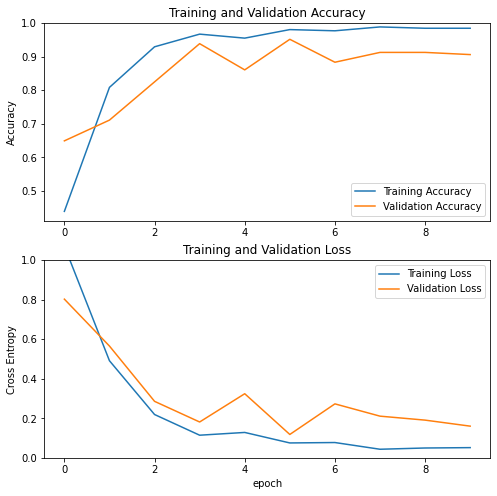

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluation and prediction

Finaly you can verify the performance of the model on new data using test set.

In [38]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 1s 78ms/step - loss: 0.1525 - accuracy: 0.9062
Test accuracy : 0.90625


And now you are all set to use this model to predict whenever the image represents a rock, paper or scissors gesture:

Predictions:
 [1 0 0 1 0 2 0 0 2 0 2 2 0 2 2 0 2 1 0 1 2 2 1 1 2 2 2 1 2 1 1 2]
Labels:
 [1 0 0 1 0 2 0 0 2 0 2 2 0 2 2 0 0 1 0 1 2 2 1 1 2 2 2 1 2 1 1 2]


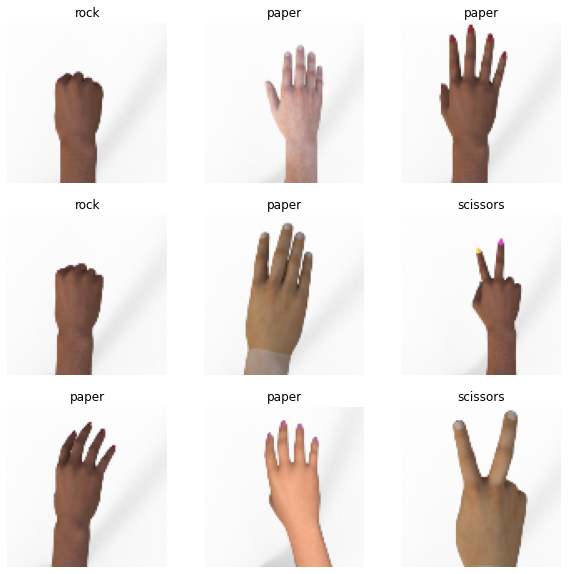

In [39]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

#Get predictions
predList = []
for pred in predictions:
  predList.append(np.argmax(pred))

predictions = np.asarray(predList)



print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Converting the models to TF Lite

We are now converting our model to a TF Lite models using the TF Lite converter.
Here we use varrying forms of quantization in order to make the binary size smaller, the memory requirements lower and the models latency shorter:


In [40]:
#TF Lite model without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()


#TF Lite model with dynamic range quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_dynamic_range = converter.convert()


#Extracts sample images needed for float fallback and full integer quantization 
def representative_data_gen():
  for input in train_dataset.take(4):
    for input_value in tf.data.Dataset.from_tensor_slices(np.array(input[0])).batch(1).take(32):
      yield [input_value]


#TF Lite model with Float Fallback quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_float_fallback = converter.convert()


#TF Lite model with Full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to int8 
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpw1oeeemb/assets
INFO:tensorflow:Assets written to: /tmp/tmpfjjo4srn/assets


INFO:tensorflow:Assets written to: /tmp/tmpfjjo4srn/assets


INFO:tensorflow:Assets written to: /tmp/tmpzst1eppo/assets


INFO:tensorflow:Assets written to: /tmp/tmpzst1eppo/assets


INFO:tensorflow:Assets written to: /tmp/tmp_icls4sf/assets


INFO:tensorflow:Assets written to: /tmp/tmp_icls4sf/assets


Now save the TF Lite models as files...

In [41]:
import pathlib

tflite_models_dir = pathlib.Path("/tmp/rps_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:

tflite_model_file = tflite_models_dir/"rps_model.tflite"
tflite_model_file.write_bytes(tflite_model)

# Save the dynamic range quantized model:

tf_model_dynamic_range_file = tflite_models_dir/"rps_model_dynamic_range.tflite"
tf_model_dynamic_range_file.write_bytes(tflite_model_dynamic_range)

# Save the float fallback quantized model:

tflite_model_float_fallback_file = tflite_models_dir/"rps_model_float_fallback.tflite"
tflite_model_float_fallback_file.write_bytes(tflite_model_float_fallback)

# Save the integer only quantized model:

tflite_model_quant_file = tflite_models_dir/"rps_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

621168

And convert them to C bytearrays via the linux command line tool xxd, in this case only the integer quantized model to show off:

In [43]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
MODEL_TFLITE = "/tmp/rps_tflite_models/rps_model_quant.tflite"
MODEL_TFLITE_MICRO = "/tmp/rps_tflite_models/rps_model_quant.cc"
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-securi

Now we define some function to help us evaluate the TF Lite model accuracy:

In [44]:
def evaluate_model(tflite_file, dataset, model_type):
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))

  interpreter.allocate_tensors()
  
  input_details = interpreter.get_input_details()[0]
  output_details =  interpreter.get_output_details()[0]

  total_seen = 0
  num_correct = 0
  is_int8_quantized = (input_details['dtype'] == np.int8)
  
  for image_batch, labels_batch in dataset:
    for i in range(tf.shape(image_batch)[0]):
      test_image = image_batch[i]
      

      if is_int8_quantized:
        input_scale, input_zero_point = input_details["quantization"]
        test_image = test_image / input_scale + input_zero_point

      test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
      interpreter.set_tensor(input_details["index"], test_image)
      interpreter.invoke()
      output = interpreter.get_tensor(output_details["index"])[0]

      output = np.argmax(output)

      if labels_batch[i] == output:
        num_correct += 1
      total_seen += 1

      if total_seen % 50 == 0:
        print("Accuracy after %i images: %f" %
              (total_seen, float(num_correct) / float(total_seen)))
  print('Num images: {0:}, Accuracy: {1:.4f}, Type: {2:}'.format(total_seen, float(num_correct / total_seen), model_type))

We get as results:

In [45]:
#Check accuracy on the test subset

evaluate_model(tflite_model_file, test_dataset, model_type="Float")
evaluate_model(tf_model_dynamic_range_file, test_dataset, model_type="Dynamic Range")
evaluate_model(tflite_model_float_fallback_file, test_dataset, model_type="Float Fallback")
evaluate_model(tflite_model_quant_file, test_dataset, model_type="Integer Quantized")
model.evaluate(test_dataset)

Accuracy after 50 images: 0.920000
Num images: 64, Accuracy: 0.9062, Type: Float
Accuracy after 50 images: 0.880000
Num images: 64, Accuracy: 0.8750, Type: Dynamic Range
Accuracy after 50 images: 0.860000
Num images: 64, Accuracy: 0.8594, Type: Float Fallback
Accuracy after 50 images: 0.940000
Num images: 64, Accuracy: 0.9219, Type: Integer Quantized
2/2 [==============================] - 1s 88ms/step - loss: 0.2732 - accuracy: 0.8281


[0.27324438095092773, 0.828125]

In [46]:
#Check accuracy on all validation data

evaluate_model(tflite_model_file, validation_dataset, model_type="Float")
evaluate_model(tf_model_dynamic_range_file, validation_dataset, model_type="Dynamic Range")
evaluate_model(tflite_model_float_fallback_file, validation_dataset, model_type="Float Fallback")
evaluate_model(tflite_model_quant_file, validation_dataset, model_type="Integer Quantized")
model.evaluate(validation_dataset)

Accuracy after 50 images: 0.920000
Accuracy after 100 images: 0.920000
Accuracy after 150 images: 0.900000
Accuracy after 200 images: 0.890000
Accuracy after 250 images: 0.884000
Accuracy after 300 images: 0.890000
Num images: 308, Accuracy: 0.8896, Type: Float
Accuracy after 50 images: 0.960000
Accuracy after 100 images: 0.910000
Accuracy after 150 images: 0.926667
Accuracy after 200 images: 0.905000
Accuracy after 250 images: 0.896000
Accuracy after 300 images: 0.900000
Num images: 308, Accuracy: 0.9026, Type: Dynamic Range
Accuracy after 50 images: 0.900000
Accuracy after 100 images: 0.860000
Accuracy after 150 images: 0.866667
Accuracy after 200 images: 0.885000
Accuracy after 250 images: 0.896000
Accuracy after 300 images: 0.893333
Num images: 308, Accuracy: 0.8929, Type: Float Fallback
Accuracy after 50 images: 0.860000
Accuracy after 100 images: 0.860000
Accuracy after 150 images: 0.873333
Accuracy after 200 images: 0.890000
Accuracy after 250 images: 0.884000
Accuracy after 300

[0.1632116436958313, 0.9025974273681641]

File size comparision:

In [47]:
print("Float model in KB:", os.path.getsize(tflite_model_file) / float(2**10))
print("Dynamic Range model in KB:", os.path.getsize(tf_model_dynamic_range_file) / float(2**10))
print("Float fallback model in KB:", os.path.getsize(tflite_model_float_fallback_file) / float(2**10))
print("Integer Quantized model in KB:", os.path.getsize(tflite_model_quant_file) / float(2**10))

Float model in KB: 2400.69140625
Dynamic Range model in KB: 607.40625
Float fallback model in KB: 606.8671875
Integer Quantized model in KB: 606.609375
